# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [56]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [57]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [58]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [59]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [60]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [61]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
    
df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [62]:
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability']

df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [65]:
#time series cv
'''from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
import numpy as np

# Параметры кросс-валидации
n_splits = 3  # количество фолдов
tscv = TimeSeriesSplit(n_splits=n_splits)

params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
}

# Подготовка данных
X = df_pd[cols].fillna(0)
y = df_pd['target']

auc_scores = []
feature_importances = []

for train_index, val_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Создаем датасеты для LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    # Обучение модели
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        callbacks=[lgb.early_stopping(stopping_rounds=60)]
    )
    
    # Оценка качества
    val_pred = model.predict(X_val)
    auc_score = roc_auc_score(y_val, val_pred)
    auc_scores.append(auc_score)
    feature_importances.append(model.feature_importance(importance_type='split'))
    
    print(f"Fold AUC: {auc_score:.4f}")

print(f"\nMean AUC: {np.mean(auc_scores):.4f} (+/- {np.std(auc_scores):.4f})")'''

'from sklearn.model_selection import TimeSeriesSplit\nfrom sklearn.metrics import roc_auc_score\nimport numpy as np\n\n# Параметры кросс-валидации\nn_splits = 3  # количество фолдов\ntscv = TimeSeriesSplit(n_splits=n_splits)\n\nparams={\n        \'objective\': \'binary\',\n        \'metric\': \'auc\',\n        \'learning_rate\': 0.01,\n        \'max_depth\': 100,\n        \'num_iterations\': 700,\n        \'early_stopping_rounds\': 60,\n        \'verbose\': 1,\n        \'importance_type\': \'split\'\n}\n\n# Подготовка данных\nX = df_pd[cols].fillna(0)\ny = df_pd[\'target\']\n\nauc_scores = []\nfeature_importances = []\n\nfor train_index, val_index in tscv.split(X):\n    X_train, X_val = X.iloc[train_index], X.iloc[val_index]\n    y_train, y_val = y.iloc[train_index], y.iloc[val_index]\n    \n    # Создаем датасеты для LightGBM\n    train_data = lgb.Dataset(X_train, label=y_train)\n    val_data = lgb.Dataset(X_val, label=y_val)\n    \n    # Обучение модели\n    model = lgb.train(\n     

In [66]:
#cv group
'''from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np

# Параметры модели
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'max_depth': 100,
    'num_iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'importance_type': 'split'
}

# Подготовка данных
groups = df_pd['user_id'].values
X = df_pd[cols].fillna(0)
y = df_pd['target']

# Кросс-валидация
gkf = GroupKFold(n_splits=3)
auc_scores = []

for train_idx, val_idx in gkf.split(X, y, groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Создаем датасеты с явным указанием валидационного набора
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    # Обучаем с валидацией для ранней остановки
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],  # Важно: передаем валидационный набор
        callbacks=[lgb.log_evaluation(50)]  # Логи каждые 50 итераций
    )
    
    val_pred = model.predict(X_val)
    auc_scores.append(roc_auc_score(y_val, val_pred))

print("AUC scores per fold:", auc_scores)
print(f"Mean AUC: {np.mean(auc_scores):.4f} (±{np.std(auc_scores):.4f})")'''

'from sklearn.model_selection import GroupKFold\nfrom sklearn.metrics import roc_auc_score\nimport lightgbm as lgb\nimport numpy as np\n\n# Параметры модели\nparams = {\n    \'objective\': \'binary\',\n    \'metric\': \'auc\',\n    \'learning_rate\': 0.05,\n    \'max_depth\': 100,\n    \'num_iterations\': 900,\n    \'early_stopping_rounds\': 60,\n    \'verbose\': 1,\n    \'importance_type\': \'split\'\n}\n\n# Подготовка данных\ngroups = df_pd[\'user_id\'].values\nX = df_pd[cols].fillna(0)\ny = df_pd[\'target\']\n\n# Кросс-валидация\ngkf = GroupKFold(n_splits=3)\nauc_scores = []\n\nfor train_idx, val_idx in gkf.split(X, y, groups):\n    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]\n    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]\n    \n    # Создаем датасеты с явным указанием валидационного набора\n    train_data = lgb.Dataset(X_train, label=y_train)\n    val_data = lgb.Dataset(X_val, label=y_val)\n    \n    # Обучаем с валидацией для ранней остановки\n    model = lgb.tra

In [ ]:
#optuna

import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import time

from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

df_pd_tttest = df_pd

tr, val = get_split(df_pd_tttest, val_size=0.25)

cols = list(set(df_pd_tttest.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

cols_test = [s for s in cols if "_x_" not in s and "^2" not in s]

# Функция для оптимизации
def objective(trial):
    # Параметры для оптимизации
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',  # или 'goss'/'dart', но не меняем в оптимизации
        'learning_rate': trial.suggest_float('eta', 0.001, 0.1, log=True),
        'num_leaves': trial.suggest_int('max_leaves', 7, 255),
        'reg_lambda': trial.suggest_float('linear_lambda', 0.0, 10.0),
        'verbose': -1,
        'importance_type': 'split',
        'early_stopping_rounds': 50  # Добавлено значение по умолчанию для early_stopping_rounds
    }
    
    # Разделение на train и validation (используем ваше исходное разделение)
    X_train = tr[cols_test]
    y_train = tr['target']
    X_val = val[cols_test]
    y_val = val['target']
    
    # Обучение модели
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(params['early_stopping_rounds'])]
    )
    
    # Прогноз на валидации
    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    return auc

# Оптимизация с ограничением времени
study = optuna.create_study(direction='maximize')
start_time = time.time()
timeout = 600  # 10 минут в секундах

while time.time() - start_time < timeout:
    study.optimize(objective, n_trials=1)
    remaining_time = timeout - (time.time() - start_time)
    if remaining_time <= 0:
        break
    print(f"Remaining optimization time: {remaining_time:.1f} seconds")

# Лучшие параметры
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Обучение финальной модели с лучшими параметрами
best_params = trial.params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'verbose': 1,
    'importance_type': 'split',
    'early_stopping_rounds': 50  # Добавлено значение по умолчанию
})

# Используем полное обучение (train + val) для финальной модели
full_train = pd.concat([tr, val])
X_train = full_train[cols_test]
y_train = full_train['target']

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Прогноз на тестовых данных
df_pd['predict'] = final_model.predict_proba(df_pd[cols_test])[:, 1]
df_pd[['user_id', 'predict']].to_csv('optimized_prod_clust.csv', index=False)

# Вывод важности фичей
plot_lgbm_importance(final_model, cols_test, importance_type='split', top_k=30, sklearn_style=True)

[I 2025-04-02 15:55:11,236] A new study created in memory with name: no-name-e51b484d-6e0f-4c72-b260-799198ff8732


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.758794


[I 2025-04-02 15:55:45,134] Trial 0 finished with value: 0.7587943142738409 and parameters: {'eta': 0.005753976130815857, 'max_leaves': 203, 'linear_lambda': 0.27910849984183583}. Best is trial 0 with value: 0.7587943142738409.


Remaining optimization time: 566.1 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 15:56:15,670] Trial 1 finished with value: 0.7571385020825124 and parameters: {'eta': 0.0010245355878322105, 'max_leaves': 221, 'linear_lambda': 8.536168864845472}. Best is trial 0 with value: 0.7587943142738409.


Remaining optimization time: 535.6 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.760913


[I 2025-04-02 15:56:45,156] Trial 2 finished with value: 0.7609132309587046 and parameters: {'eta': 0.03338298818076295, 'max_leaves': 186, 'linear_lambda': 0.7411072226125393}. Best is trial 2 with value: 0.7609132309587046.


Remaining optimization time: 506.1 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.758269


[I 2025-04-02 15:57:16,525] Trial 3 finished with value: 0.7582686657129613 and parameters: {'eta': 0.0036316226595143274, 'max_leaves': 192, 'linear_lambda': 3.9085294848524743}. Best is trial 2 with value: 0.7609132309587046.


Remaining optimization time: 474.7 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.76148


[I 2025-04-02 15:57:44,897] Trial 4 finished with value: 0.7614798618522485 and parameters: {'eta': 0.058489285577714066, 'max_leaves': 250, 'linear_lambda': 2.016487773061969}. Best is trial 4 with value: 0.7614798618522485.


Remaining optimization time: 446.3 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 15:58:17,434] Trial 5 finished with value: 0.7594493355581672 and parameters: {'eta': 0.009802049444213578, 'max_leaves': 229, 'linear_lambda': 6.0526416967835726}. Best is trial 4 with value: 0.7614798618522485.


Remaining optimization time: 413.8 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 15:58:39,233] Trial 6 finished with value: 0.7562383644117345 and parameters: {'eta': 0.002175059675050819, 'max_leaves': 61, 'linear_lambda': 4.505777069815896}. Best is trial 4 with value: 0.7614798618522485.


Remaining optimization time: 392.0 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[82]	valid_0's auc: 0.76144


[I 2025-04-02 15:59:00,591] Trial 7 finished with value: 0.7614399614483105 and parameters: {'eta': 0.08589480855780353, 'max_leaves': 156, 'linear_lambda': 0.16223969578818775}. Best is trial 4 with value: 0.7614798618522485.


Remaining optimization time: 370.6 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 15:59:22,793] Trial 8 finished with value: 0.7615299437616896 and parameters: {'eta': 0.07461707429193765, 'max_leaves': 126, 'linear_lambda': 1.1476341440232518}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 348.4 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 15:59:33,748] Trial 9 finished with value: 0.7469954200336574 and parameters: {'eta': 0.003443886951657655, 'max_leaves': 10, 'linear_lambda': 1.694159731143291}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 337.5 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 15:59:59,427] Trial 10 finished with value: 0.7603840429028537 and parameters: {'eta': 0.029024461473570132, 'max_leaves': 106, 'linear_lambda': 6.643940931290837}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 311.8 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.761411


[I 2025-04-02 16:00:18,480] Trial 11 finished with value: 0.7614110347059256 and parameters: {'eta': 0.09929560074074607, 'max_leaves': 117, 'linear_lambda': 2.5435972027784635}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 292.8 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.761276


[I 2025-04-02 16:00:45,252] Trial 12 finished with value: 0.7612759974476149 and parameters: {'eta': 0.04483569133583914, 'max_leaves': 151, 'linear_lambda': 2.412381016646569}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 266.0 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.759106


[I 2025-04-02 16:01:09,294] Trial 13 finished with value: 0.7591060797751168 and parameters: {'eta': 0.01668992925232527, 'max_leaves': 80, 'linear_lambda': 3.366742147560524}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 241.9 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.76148


[I 2025-04-02 16:01:34,964] Trial 14 finished with value: 0.7614798468527246 and parameters: {'eta': 0.054775106237588495, 'max_leaves': 156, 'linear_lambda': 1.815349221395318}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 216.3 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 16:02:08,025] Trial 15 finished with value: 0.7604164736346261 and parameters: {'eta': 0.020931863843343584, 'max_leaves': 248, 'linear_lambda': 5.710755491483637}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 183.2 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 16:02:27,756] Trial 16 finished with value: 0.7610474986407854 and parameters: {'eta': 0.06082166860447112, 'max_leaves': 54, 'linear_lambda': 8.010129149443532}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 163.5 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.758941


[I 2025-04-02 16:02:53,877] Trial 17 finished with value: 0.7589409104066623 and parameters: {'eta': 0.01306232565758967, 'max_leaves': 98, 'linear_lambda': 3.22849406485317}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 137.4 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 16:03:22,883] Trial 18 finished with value: 0.7607176707936911 and parameters: {'eta': 0.030710006571678064, 'max_leaves': 143, 'linear_lambda': 1.3402992099016808}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 108.4 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.75624


[I 2025-04-02 16:03:38,186] Trial 19 finished with value: 0.7562404300978078 and parameters: {'eta': 0.007657733467544287, 'max_leaves': 23, 'linear_lambda': 9.532939350964652}. Best is trial 8 with value: 0.7615299437616896.


Remaining optimization time: 93.1 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 16:04:03,734] Trial 20 finished with value: 0.7615808228001764 and parameters: {'eta': 0.06804300332125043, 'max_leaves': 177, 'linear_lambda': 4.8874458472638995}. Best is trial 20 with value: 0.7615808228001764.


Remaining optimization time: 67.5 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[83]	valid_0's auc: 0.761492


[I 2025-04-02 16:04:28,877] Trial 21 finished with value: 0.7614920014297927 and parameters: {'eta': 0.08162408960638788, 'max_leaves': 255, 'linear_lambda': 4.677513823142757}. Best is trial 20 with value: 0.7615808228001764.


Remaining optimization time: 42.4 seconds
Training until validation scores don't improve for 50 rounds


[I 2025-04-02 16:04:52,779] Trial 22 finished with value: 0.7616819412531695 and parameters: {'eta': 0.07949490935365787, 'max_leaves': 180, 'linear_lambda': 5.351622966131136}. Best is trial 22 with value: 0.7616819412531695.


Remaining optimization time: 18.5 seconds
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.761208


[I 2025-04-02 16:05:21,499] Trial 23 finished with value: 0.7612082258751505 and parameters: {'eta': 0.039558030258354, 'max_leaves': 180, 'linear_lambda': 7.305592115798058}. Best is trial 22 with value: 0.7616819412531695.


Best trial:
  AUC: 0.7616819412531695
  Params: 
    eta: 0.07949490935365787
    max_leaves: 180
    linear_lambda: 5.351622966131136
[LightGBM] [Warning] num_leaves is set=31, max_leaves=180 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07949490935365787 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Warning] num_leaves is set=31, max_leaves=180 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.07949490935365787 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Info] Number of positive: 647575, number of negative: 1227380
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.315425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21268
[LightGBM]

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [ ]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

tr, val = get_split(df_pd_tttest, val_size=0.25)

cols = list(set(df_pd_tttest.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 900,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model(tr, val, cols_test, 'target', params=params, shadow_features=False, sklearn_style=True)


[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 485658, number of negative: 920558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.102304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21289
[LightGBM] [Info] Number of data points in the train set: 1406216, number of used features: 109
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345365 -> initscore=-0.639475
[LightGBM] [Info] Start training from score -0.639475
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 60 rounds
Did not meet early stopping. Best iteration i

feature_importance: [ 201   60  566   93  302  157  325  667  504  486 1477  174  119  509
   54  798  327  248  163   46  238 1521   67   50   62  211   76  214
   50    0   71  503   85  350   59    8  283    0  136  123   17   49
  122  271   41   38   98   61   26  707  222  131  690   88   54  128
  404  222  375  759  520  224  232  400  284  132  158   69  199  732
   11  144  353  329   41   20   53  258    0  909   11  888   98   40
   40  193  546  155    0    4  105  662   29   69   12   53  302   52
    0  473  373   51    0   63 1297   23    0  457   50] 



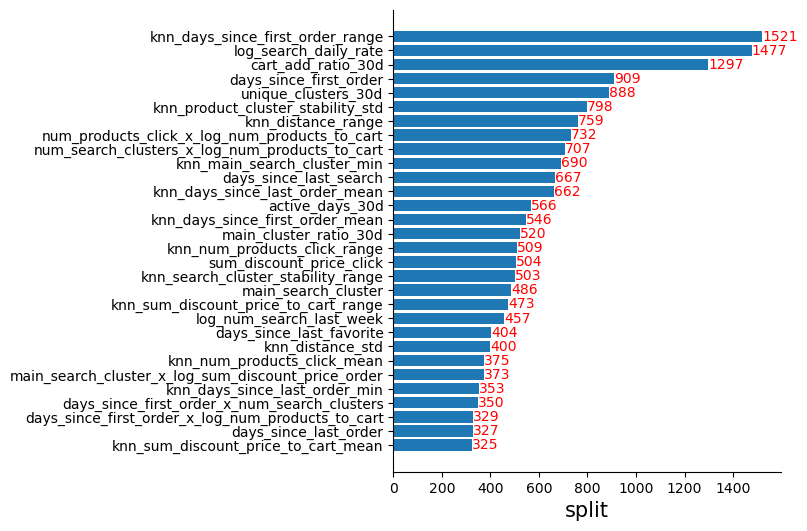

In [94]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [70]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [71]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [72]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [73]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_17812\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [74]:
from local_utils import *

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')

test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [75]:
test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [97]:
test_df_pd['predict'] = model.predict_proba(test_df_pd[cols_test])[:, 1]
#test_df_pd['predict'] = model.predict(test_df_pd[cols])

In [98]:
test_df_pd[['user_id', 'predict']]

,user_id,predict
0,1342,0.166272
1,9852,0.782111
2,10206,0.226123
3,11317,0.228409
4,13289,0.653483
...,...,...
2068419,11157283,0.198232
2068420,11160395,0.148807
2068421,11165052,0.626269
2068422,11168218,0.464322


In [99]:
test_df_pd[['user_id', 'predict']].to_csv('all_together.csv', index=False)